In [55]:
from datasets import load_dataset
import pandas
import os
from dotenv import load_dotenv
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pandas
import openai
from openai import APIError
import os
import json
import re
import numpy as np
from sklearn.cluster import KMeans


# Load the .env file
load_dotenv()

# Access the variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_KEY


In [2]:
dataset = load_dataset("jerteh/SrpWiki")
dataset2 = load_dataset("jerteh/SrpKorNews")


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3818535
    })
})

In [5]:
dataset['train']

Dataset({
    features: ['text'],
    num_rows: 3818535
})

In [7]:
wikiText = dataset['train']['text']
len(wikiText)

3818535

In [8]:
for i in range(10):
    print(wikiText[i])

UTF-8 UTF-8 varijanta je najzgodnija za kodiranje većinski latiničnog teksta.
Dato je i kratko uputstvo za korišćenje te varijante u Microsoft Word-u, Netscape Composer-u i tekstualnom editoru Kate.
U tekstu su takođe preporučeni standardni Unicode fontovi koji omogućavaju laku prenosivost teksta sa računara na računar ili za objavljivanje teksta na Internet.
Prvi računari su bili pravljeni pretežno za englesko govorno područje i imali su podršku samo za engleski alfabet, za brojeve, zagrade i još po neki kontrolni karakter, što je činilo ukupno 128 mogućih slova (u 7 bita).
To je bio tzv. "-{ASCII}-" ili "-{US-ASCII}-" standard.
1968. godine je skup karaktera proširen na 256 (8 bita), a "gornjih" 128 karaktera je bilo korišćeno za dodatne karaktere.
Iz neke navike je i ovaj prošireni "-{ASCII}-" nazivan "-{ASCII}-", tako da tu često dolazi do zabune.
Da bi postojala podrška za više jezika, smišljane su tzv. kodne strane ("-{Code Page}-") koje definišu ponašanje tog dodatnog skupa slov

In [30]:
context = "UTF-8 UTF-8 varijanta je najzgodnija za kodiranje većinski latiničnog teksta. Dato je i kratko uputstvo za korišćenje te varijante u Microsoft Word-u, Netscape Composer-u i tekstualnom editoru Kate.U tekstu su takođe preporučeni standardni Unicode fontovi koji omogućavaju laku prenosivost teksta sa računara na računar ili za objavljivanje teksta na Internet."
PROMPT = """
### Goal ###
Tre primary objective is to produce a query in the Serbian language and a list of keywords in the Serbian language from the provided context. The context repesents an answer to the query and the keywords best 
describe the context. The goal is to have query-context pairs that corelate with each other and a list of keywords that would spead-up the search in the future.

### Process Overview ###
1. Carefully read and analyze the given context text.
2. Identify all relevant keywords and what the context text is about.
3. Find the query that best represents the given context text.

### Formatting Rules ###
- Keyword value MUST be a LIST of strings with max lenght of 5 or [null] if no relevant information is provided.
- Use double quotes for strings and escape internal quotes with a backslash (\).
- Keep the query concise and general about the context text.
- Ensure the output is a valid JSON file, parsable by Python's json.loads().
- Strictly use only the information provided in the context text. Do not add, infer, or imagine any additional details beyond what is explicitly stated.
- Remember to answer in Serbian

### Output Format ###
{{
 "keywords": ["The keyword that best represent the given context"]
 "query": "The query that best suits the given context"
}}

### Context ###
{context}
"""

In [28]:
PROMPT

'\n### Goal ###\nTre primary objective is to produce a query in the serbian language and a list of keywords in the serbian language from the provided context. The context would repesent the answer to the query and the keywords best \ndescribe the context. The goal is to have query-context pairs that corelate with eachother and a list of keyword that would spead-up the search in the future.\n\n### Process Overview ###\n1. Carefully read and analyze the given context text.\n2. Identify all relevant keywords and what the context text is about.\n3. Find the query that best represents the given context text.\n\n### Formatting Rules ###\n- Keyword value MUST be a LIST of strings with max lenght of 5 or [null] if no relevant information is provided.\n- Use double quotes for strings and escape internal quotes with two backslashes (\\\\).\n- Keep the query concise and general about the context text.\n- Ensure the output is a valid JSON file, parsable by Python\'s json.loads().\n- Strictly use o

In [31]:

def test_api(prompt, context, model: str = "gpt-3.5-turbo-0125"):
    client = openai


    # Assuming OpenAI API key is set elsewhere
    # Initiate the streaming response
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": context}
        ],
        response_format={'type': 'json_object'},
        temperature=0,
        top_p=1
    )

    return response


In [35]:
res = test_api(PROMPT, context)
returned_obj = res.choices[0].message.content
json.loads(returned_obj)

{'keywords': ['UTF-8',
  'kodiranje',
  'latinični tekst',
  'Microsoft Word',
  'Unicode fontovi'],
 'query': 'Kako koristiti UTF-8 varijantu za kodiranje latiničnog teksta u Microsoft Word-u i Netscape Composer-u?'}

In [56]:
from openai import OpenAI
client = OpenAI()

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)
    


def get_embedding(text, model="text-embedding-3-small", dimension=None):
    text = text.replace("\n", " ")

    embedded_text = client.embeddings.create(input = [text], model=model).data[0].embedding
    if not dimension:
       return embedded_text
    cut_dim = embedded_text[:dimension]
    return normalize_l2(cut_dim)


embedding = get_embedding("recenica akldakjdn jakjaaj jjjjjj", dimension=768)
len(embedding)
# 1536
# 768 je outoutovih srpskih
# zakljucak, treba redukcija dimenzionalnosti

768

In [58]:

jump = 4
new_contexts = []
for i in range(0, 10 * 3, jump):
    context = ' '.join(wikiText[i:i+jump])
    print(context)
    new_contexts.append(context)
    # print(len(context.split(". ")))


# context_embeddings = new_contexts.apply(lambda x: get_embedding(x))

df = pandas.DataFrame({
    'context': new_contexts
    })

df['embedding'] = df['context'].apply(lambda x: get_embedding(x))

matrix = np.vstack(df.embedding.values)
n_clusters = 4

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

df.head()


UTF-8 UTF-8 varijanta je najzgodnija za kodiranje većinski latiničnog teksta. Dato je i kratko uputstvo za korišćenje te varijante u Microsoft Word-u, Netscape Composer-u i tekstualnom editoru Kate. U tekstu su takođe preporučeni standardni Unicode fontovi koji omogućavaju laku prenosivost teksta sa računara na računar ili za objavljivanje teksta na Internet. Prvi računari su bili pravljeni pretežno za englesko govorno područje i imali su podršku samo za engleski alfabet, za brojeve, zagrade i još po neki kontrolni karakter, što je činilo ukupno 128 mogućih slova (u 7 bita).
To je bio tzv. "-{ASCII}-" ili "-{US-ASCII}-" standard. 1968. godine je skup karaktera proširen na 256 (8 bita), a "gornjih" 128 karaktera je bilo korišćeno za dodatne karaktere. Iz neke navike je i ovaj prošireni "-{ASCII}-" nazivan "-{ASCII}-", tako da tu često dolazi do zabune. Da bi postojala podrška za više jezika, smišljane su tzv. kodne strane ("-{Code Page}-") koje definišu ponašanje tog dodatnog skupa slov

context  \
0  UTF-8 UTF-8 varijanta je najzgodnija za kodira...   
1  To je bio tzv. "-{ASCII}-" ili "-{US-ASCII}-" ...   
2  Osnovna kodna strana na personalnim računarima...   
3  To uglavnom nije problem realizovati, ali ako ...   
4  Njen naziv je UCS-2 zato što koristi dva oktet...   

                                           embedding  Cluster  
0  [-0.03119899518787861, 0.021681327372789383, 0...        2  
1  [-0.023562924936413765, 0.006283111404627562, ...        0  
2  [-0.018423281610012054, 0.030895544216036797, ...        0  
3  [-0.017615992575883865, -0.0014623641036450863...        1  
4  [-0.0020054560154676437, 0.002966209314763546,...        1

/home/selena/sele/SRBedding/.venv/lib/python3.10/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/selena/sele/SRBedding/.venv/lib/python3.10/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


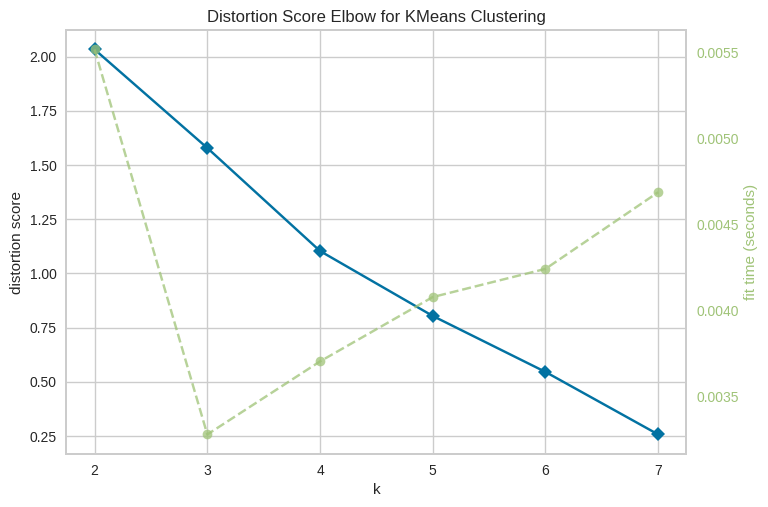

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,8))

visualizer.fit(matrix)        # Fit the data to the visualizer
visualizer.show() 

In [37]:
t1 = "sdsd 'sssd' dsfds"
t2 = '"sdsd sssd dsfds'

t1 + t2

'sdsd \'sssd\' dsfds"sdsd sssd dsfds'

In [38]:
dataset2

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 337
    })
})

In [40]:
dataset2['train']

Dataset({
    features: ['text'],
    num_rows: 337
})

In [41]:
dataset2['train']['text'][0]

'<s>Mečka na usijanom limenom krovu</s><s>Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.</s><s>Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a istorija automobilizma je imala sreću da je Jelinekovoj mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, prijatnost.</s><s>Jelinekova porudžbina značila prekretnicu u poslovanju Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom Karla Benca, 1926. godine, održavši se do danas kao sinonim za kvalitetne, luksuzne i, nadasve, bezbedne automobile svojstvenih vozačima koji ne kriju brige u novčaniku.</s><s>Međutim, upravo legenda o blistavosti trokrake zvezde doživljava ovih dana ozbiljnu proveru zahvaljujući mercedesu A klase.</s><s>A 

In [61]:
count = 0
for paragraf in dataset2['train']['text']:
    sentences = re.findall(r'<s>(.*?)</s>', paragraf)
    count += len(sentences)
    # print(len(sentences))
print(count)


21982152


In [54]:
for sentence in sentences:
    print(sentence)

Uravnost u naherenom svetu
Knjiga Dragoslave Barzut, iako svakako samosvojna, može se kontekstualno čitati i kao deo nekovrsne "Red box poetike" u nastajanju Mada ne verujem u tzv. generacije – kolektivizam kao i bilo koji drugi, odbojan i zasnovan na lažnoj bliskosti po nevažnim kriterijumima – možda ću morati bar na trenutak da reteriram, iz puke nužde: toliko je ono što nazivamo savremenom srpskom prozom, čast izuzecima, ustajalo i ukiseljeno, da ne mogu odoleti iskušenju da ne investiram neku pomalo očajničku nadu u naraštaj koji tek hvata pravi zalet na sceni, recimo, one koji sada imaju oko trideset, najviše trideset i pet godina.
Dobro, u tim je godinama Tomas Man već bio napisao neke od svojih ključnih knjiga, ali manimo se mi takvih poređenja...
Jer, ako "nas" oni i one ne izvuku iz jalovog koegzistiranja izanđalih paradigmi, recimo odlikaško-postmodernističke na jednoj, a "tradicionalističke" (zapravo jalovo provincijalne) na drugoj, onda piši propalo...
A ponekog znaka da se